In [1]:
from fastai.vision.all import *
import fastprogress
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2, json, ast, urllib
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import optim
import kornia as K
from map_boxes import mean_average_precision_for_boxes
import xml.etree.ElementTree as ET
from torch.cuda.amp import autocast
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import warnings
warnings.filterwarnings('ignore')

In [2]:
pot_dir = Path('/home/ubuntu/data/det/potholes')
mask_dir = Path('/home/ubuntu/data/det/masks')
circuit_dir = Path('/home/ubuntu/data/circuits')

In [3]:
def extract_coords(boxes):
    y_min = int(boxes.find("bndbox/ymin").text)
    x_min = int(boxes.find("bndbox/xmin").text)
    y_max = int(boxes.find("bndbox/ymax").text)
    x_max = int(boxes.find("bndbox/xmax").text)
    return x_min, y_min, x_max, y_max

def read_annot(file_name):
    bbox = []
    labels = []
    
    annot_path = file_name
    tree = ET.parse(annot_path)
    root = tree.getroot()
    for boxes in root.iter('object'):
        x_min, y_min, x_max, y_max = extract_coords(boxes)
        label = boxes.find('name').text
        bbox.append([x_min, y_min, x_max, y_max])
        labels.append(label)
    df = pd.DataFrame(columns='label,x1,y1,x2,y2'.split(','))
    df['x1,y1,x2,y2'.split(',')] = bbox
    df['label'] = labels
    return df

def get_labels(root):
    labels = set()
    filter_xml = lambda x: str(x).endswith('.xml')
    fs = get_files(root/'annotations').filter(filter_xml)
    for f in fs:
        tree = ET.parse(f)
        root = tree.getroot()
        for boxes in root.iter('object'):
            label = boxes.find('name').text
            labels.add(label)
    return list(labels)

def proc_coco(fs):
    items = dict()
    for f in fs:
        file = ast.literal_eval(f.read_text())[0]
        o = pd.DataFrame(file['annotations'])
        f_name = file['image']
        if o.shape[0]>0:
            coords = np.array(o['coordinates'].apply(lambda x: list(x.values())).values.tolist())
            o['x1,y1,x2,y2'.split(',')] = xcycwh2xyxy(coords)
            o.drop(columns='coordinates', inplace=True)
        else:
            o = pd.DataFrame({'label': ['none'], 'x1': [0], 'y1': [0], 'x2': [1], 'y2': [1]})
        items[f.stem + '.' + f_name.split('.')[-1]] = o
    return items
      
def proc_pascal(fs, ext):
    items = dict()
    xml_dir = fs[0].parent.parent/'annotations'
    for f in fs:
        img_name = f.stem + '.xml'
        xml_file = xml_dir/img_name
        items[f.stem + ext] = read_annot(xml_file)
    return items

In [4]:
def xcycwh2xyxy(o):
    xc, yc, w, h = np.split(o, 4, axis=1)
    x1 = xc - w/2
    x2 = xc + w/2
    y1 = yc - h/2
    y2 = yc + h/2
    return np.concatenate([x1, y1, x2, y2], axis=1)

def clip_bbox(df, w, h):
    df['x1'].clip(0, w-1, inplace=True)
    df['x2'].clip(0, w, inplace=True)
    df['y1'].clip(0, h-1, inplace=True)
    df['y2'].clip(0, h, inplace=True)
    
def xyxy2area(o):
    x1, y1, x2, y2 = np.split(o, 4, axis=1)
    w = x2 - x1
    h = y2 - y1
    return w * h

In [5]:
def get_train_tfms():
    tfms = A.Compose([
                      A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
                     A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.9)], p=0.9),
                     A.HorizontalFlip(p=0.5),
                     A.VerticalFlip(p=0.5),
                     A.Resize(height=512, width=512, p=1.0),
                     A.Cutout(num_holes = 8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
                     ToTensorV2(p=1.0), ], p=1.0,
                     bbox_params = A.BboxParams(format= 'pascal_voc',
                                               min_area=0,
                                               min_visibility=0,
                                               label_fields=['labels'])
                    )
    return tfms

def get_valid_tfms():
    tfms = A.Compose([A.Resize(height=512, width=512, p=1.0),
                     ToTensorV2(p=1.0)], p=1.0,
                    bbox_params = A.BboxParams(format='pascal_voc',
                                              min_area=0,
                                              min_visibility=0,
                                              label_fields=['labels']))
    return tfms

In [6]:
class RCNNDataset(Dataset):
    def __init__(self, fs, augs):
        self.fs = fs
        self.augs = augs   
    
    @classmethod
    def from_coco(cls, root):
        cls.root = root
        filter_json = lambda x: str(x).endswith('.json')
        fs = get_files(Path(root)/'annotations').filter(filter_json)
        cls.targs = proc_coco(fs)
        c =list(sorted(pd.concat(list(cls.targs.values()))['label'].unique().tolist()))
        if 'none' in c: c.remove('none')
        cls.c = ['none'] + c
        cls.encs = {j:i for i,j in enumerate(cls.c)}
        cls.rev_encs = {j:i for i,j in cls.encs.items()}
        x_train, x_val = train_test_split(list(cls.targs.keys()), 
                                          test_size=0.2, random_state=2021)
        return cls(x_train, get_train_tfms()), cls(x_val, get_valid_tfms())
            
    @classmethod
    def from_pascal(cls, root):
        cls.root = root
        ext = (root/'images').ls()[0].suffix
        cls.targs = proc_pascal(get_image_files(root/'images'), ext)
        c = sorted(get_labels(root))
        if 'none' in c: c.remove('none')
        cls.c = ['none'] + c
        cls.encs = {j:i for i,j in enumerate(cls.c)}
        cls.rev_encs = {j:i for i,j in cls.encs.items()}
        x_train, x_val = train_test_split(list(cls.targs.keys()),
                                          test_size=0.2, random_state=2021)
        return cls(x_train, get_train_tfms()), cls(x_val, get_valid_tfms())
    
    def __len__(self): return len(self.fs)
    
    def __getitem__(self, idx):
        name = self.fs[idx]
        img = cv2.cvtColor(cv2.imread(os.path.join(self.root, 'images', name)), cv2.COLOR_BGR2RGB)
        targs = self.targs[name]
        bboxes = clip_bbox(targs, *img.shape[:-1])
        if self.augs:
            temp = {}
            bboxes = targs.loc[:, 'x1,y1,x2,y2'.split(',')]
            sample = {'image': img,
                      'bboxes': targs.loc[:, 'x1,y1,x2,y2'.split(',')].values, 
                      'labels': targs.loc[:, 'label'].map(self.encs)}
            sample = self.augs(**sample)
            img = sample['image']
            if sample['bboxes']!=[]:
                temp['boxes'] = torch.stack(tuple(map(partial(torch.tensor, dtype=torch.float32),
                                                                zip(*sample['bboxes'])))).permute(1,0).float()
                temp['labels'] = torch.tensor(sample['labels']).long()
                if torch.equal(temp['boxes'], torch.tensor([[1., 1., 1., 1.]])):
                    temp['boxes'] == torch.tensor([[1., 1., 2., 2.]]).float()
                    temp['labels'] = torch.zeros(1).long()
                temp['area'] = xyxy2area(temp['boxes'])
                temp['iscrowd'] = torch.zeros_like(temp['area'], dtype=torch.int64)
            else: return img, {'boxes': torch.tensor([[1, 1, 2, 2]]).float(), 
                               'labels': torch.zeros(1).long(), 
                               'area': torch.ones(1),
                               'iscrowd': torch.zeros(1)}
        return img, temp

In [7]:
train_ds, val_ds = RCNNDataset.from_coco(circuit_dir)

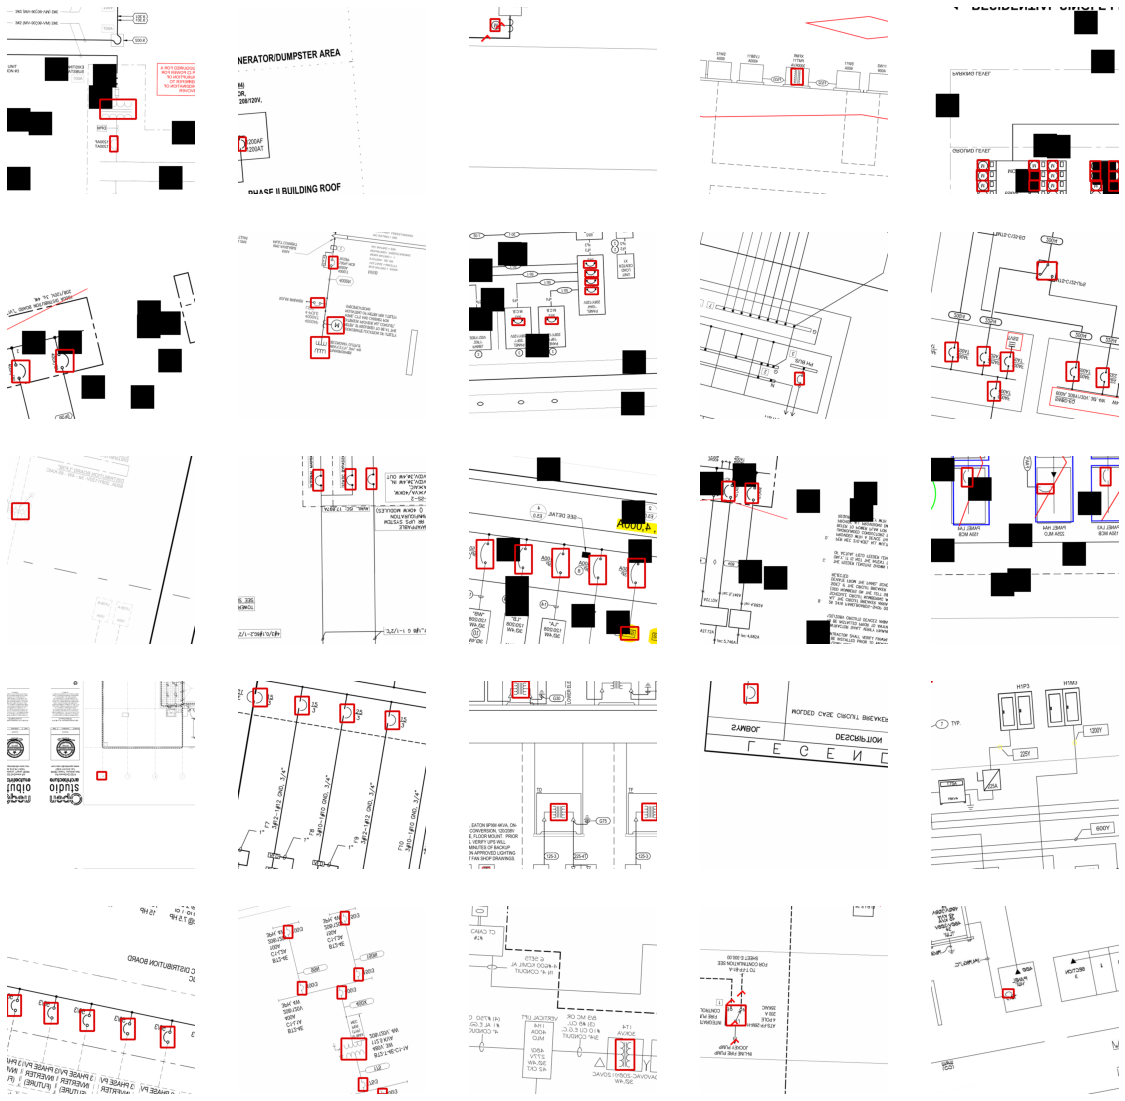

In [8]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

for k, ax in enumerate(axes.ravel()):
    x, y = random.choice(train_ds)
    img = x.permute(1, 2, 0).numpy()

    for box in y['boxes'].long().numpy():
        cv2.rectangle(img,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3
                     )
    ax.imshow(img)
    ax.axis('off')

In [9]:
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [10]:
def _noop_normalize(image: Tensor) -> Tensor:
    return image

def _noop_resize(image, target):
    return image, target

def remove_internal_model_transforms(model):
#     model.transform.normalize = _noop_normalize
    model.transform.resize = _noop_resize

In [11]:
def get_faster_rcnn(train_ds):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    num_classes = len(train_ds.c)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    remove_internal_model_transforms(model)
    return model

In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [13]:
def proc_pred(image_id, train_ds, d):
    temp = pd.DataFrame(columns='ImageID,LabelName,Conf,XMin,XMax,YMin,YMax'.split(','))
    temp['XMin,XMax,YMin,YMax'.split(',')] = d['boxes']
    temp['LabelName'] = list(map(lambda x: train_ds.rev_encs[x.item()], d['labels']))
    temp['Conf'] = d['scores'].detach().cpu().numpy()
    temp['ImageID'] = image_id
    return temp
              
def proc_targ(image_id, train_ds, d):
    temp = pd.DataFrame(columns='ImageID,LabelName,XMin,XMax,YMin,YMax'.split(','))
    temp['XMin,XMax,YMin,YMax'.split(',')] = d['boxes'].cpu().numpy()
    temp['LabelName'] = list(map(lambda x: train_ds.rev_encs[x.item()], d['labels'].cpu().numpy()))
    temp['ImageID'] = image_id
    return temp

In [14]:
def train_loop(model, opt, dl, sched):
    model.train()
    loss_acc = []
    for k, (images, targ) in enumerate(dl):
        images = [image.cuda()/255.0 for image in images]
        targ = [{k: v.cuda() for k,v in t.items()} for t in targ]
        with autocast():
            loss_dict = model(images, targ)
            loss = sum(loss for loss in loss_dict.values())
            loss_acc.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        opt.step()
        sched.step()
        opt.zero_grad()
    return np.array(loss_acc).mean()

def val_loop(model, dl, train_ds):
    pred_acc, targ_acc = [], []
    model.eval()
    with torch.no_grad():
        for k, (images, targ) in enumerate(dl):
            images = [image.cuda()/255.0 for image in images]
            output = model(images)
            for i, (pred, targ) in enumerate(zip(output, targ)):
                pred_acc.append(proc_pred(str(k*dl.batch_size+i), train_ds, pred))
                targ_acc.append(proc_targ(str(k*dl.batch_size+i), train_ds, targ))
    
    targ_df = pd.concat(targ_acc, ignore_index=True)
    targ_df = targ_df[targ_df['LabelName'] != 'none']
    pred_df = pd.concat(pred_acc, ignore_index=True)
    pred_df = pred_df[pred_df['LabelName'] != 'none']
    mean_ap, average_precisions = mean_average_precision_for_boxes(targ_df.values, pred_df.values, iou_threshold=0.4)
    return mean_ap

In [15]:
def apply_mod(m, f):
    f(m)
    for l in m.children(): apply_mod(l, f)

def set_grad(m, b):
    if isinstance(m, (nn.Linear,nn.BatchNorm2d)): return
    if hasattr(m, 'weight'):
        for p in m.parameters(): p.requires_grad_(b)

In [16]:
def run_one_cycle(model, opt, lr, epochs, train_dl, val_dl, train_ds):
    sched = optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, steps_per_epoch=len(train_dl), epochs=epochs)
    for epoch in range(epochs):
        train_loss = train_loop(model, opt, train_dl, sched)
        print('train_loss : ', train_loss)
        val_loss = val_loop(model, val_dl, train_ds)

In [17]:
def train_rcnn(root):
    train_ds, val_ds = RCNNDataset.from_coco(circuit_dir)
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True, pin_memory=True, num_workers=4, collate_fn=collate_fn, drop_last=True)
    val_dl = torch.utils.data.DataLoader(val_ds, batch_size=8, pin_memory=True, num_workers=4, collate_fn=collate_fn)
    model = get_faster_rcnn(train_ds).cuda()
    opt = optim.Adam(model.parameters(), lr=1e-3)
    apply_mod(model.backbone.body, partial(set_grad, b=False))
    run_one_cycle(model, opt, 1e-3, 3, train_dl, val_dl, train_ds)
    apply_mod(model.backbone.body, partial(set_grad, b=True))
    run_one_cycle(model, opt, 1e-4, 3, train_dl, val_dl, train_ds)

In [18]:
train_rcnn(circuit_dir)

train_loss :  0.48039827014939246


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Number of files in annotations: 1004
Number of files in predictions: 1005
Unique classes: 5
Detections length: 1005
Annotations length: 1004
ats                            | 0.185225 |     140
breaker                        | 0.181010 |    2549
motor                          | 0.151511 |     935
spd                            | 0.120981 |     227
transformer                    | 0.120523 |     253
mAP: 0.151850


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss :  0.3966644928156142


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Number of files in annotations: 1004
Number of files in predictions: 1004
Unique classes: 5
Detections length: 1004
Annotations length: 1004
ats                            | 0.253187 |     140
breaker                        | 0.185400 |    2549
motor                          | 0.181015 |     935
spd                            | 0.149038 |     227
transformer                    | 0.171603 |     253
mAP: 0.188049


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss :  0.3188949201211511


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Number of files in annotations: 1004
Number of files in predictions: 1004
Unique classes: 5
Detections length: 1004
Annotations length: 1004
ats                            | 0.271755 |     140
breaker                        | 0.188942 |    2549
motor                          | 0.177568 |     935
spd                            | 0.174013 |     227
transformer                    | 0.169653 |     253
mAP: 0.196386


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss :  0.29948873525537345


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Number of files in annotations: 1004
Number of files in predictions: 1004
Unique classes: 5
Detections length: 1004
Annotations length: 1004
ats                            | 0.241516 |     140
breaker                        | 0.188622 |    2549
motor                          | 0.172263 |     935
spd                            | 0.161720 |     227
transformer                    | 0.178070 |     253
mAP: 0.188438


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


KeyboardInterrupt: 